# Summary

Dans ce notebook, nous allons mettre en pratique les algorithmes de regression sur un jeu de données relatif aux prix de biens immobilliers à Ames, Iowa.

Pour rappel, voici **quelques étapes de travail** d'un **Data Scientist** sont les suivantes:

<img src=attachment:f51f71af-8592-414e-a490-2c6d3bbcfe46.png width=700>


**Outils:**
- **Collecte et exploration des données**: pandas, polar, missingno, ydata-profiling, seaborn, plotly, ...
- **Modélisaion**: lazypredict sklearn, xgboost, lightgbm, catboost, yellowbricks, ...
- **Optimisation des hyperparamètres**: gridsearch (sklearn), optuna, hyperopt, ...
- **Déploiement**: mlflow, fastapi, evidently, heroku, pythonanywhere, azure webapp, ...
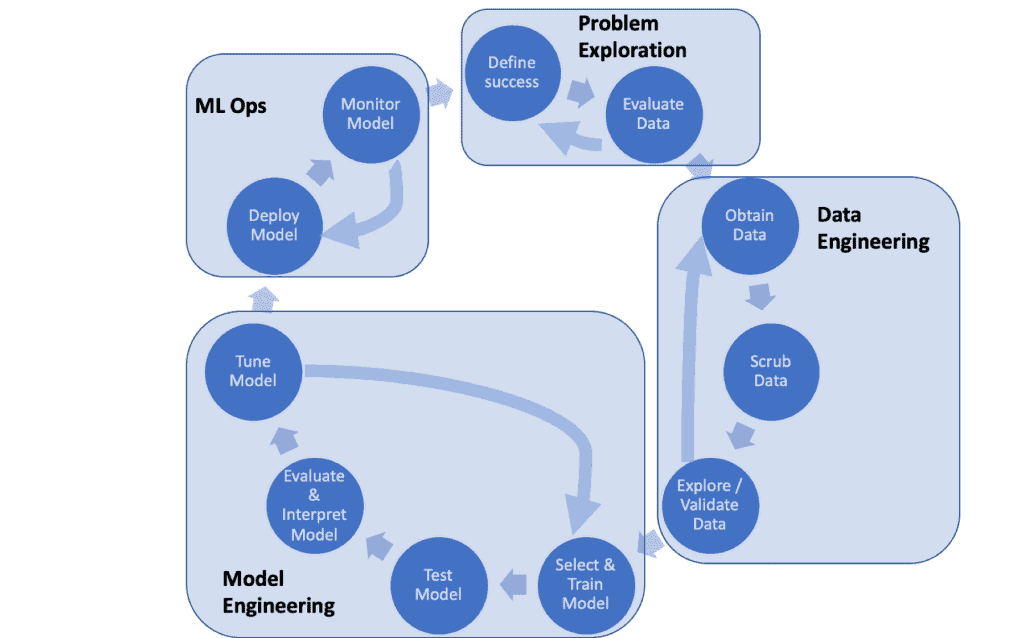

# Sources utiles

- [Introduction à MLOps](https://ashutoshtripathi.com/2021/08/18/mlops-a-complete-guide-to-machine-learning-operations-mlops-vs-devops/)

- [MLFLOW - Site de référence](https://mlflow.org/docs/latest/index.html)
- [MLFLOW - Tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html)
- [MLFLOW - Tracking](https://mlflow.org/docs/latest/tracking.html)
- [MLFLOW - Model Registry](https://mlflow.org/docs/latest/model-registry.html#)
- [MLFLOW - Serve a model](https://mlflow.org/docs/latest/model-registry.html#serving-an-mlflow-model-from-model-registry)

- [Evidently - tutorial d'analyse de Data drift](https://github.com/evidentlyai/evidently/tree/main/examples/sample_notebooks)
- [API Flask - Démarche de mise en oeuvre](http://web.univ-ubs.fr/lmba/lardjane/python/c4.pdf)
- [FastAPI - Démarche de mise en oeuvre](https://towardsdatascience.com/how-to-build-and-deploy-a-machine-learning-model-with-fastapi-64c505213857)
- [Azure - Tuto déploiement application web ](https://learn.microsoft.com/fr-fr/azure/app-service/quickstart-python?tabs=flask%2Cwindows%2Cazure-portal%2Cvscode-deploy%2Cdeploy-instructions-azportal%2Cterminal-bash%2Cdeploy-instructions-zip-azcli)
- [Tests unitaires - Unittest ou Pytest](https://www.sitepoint.com/python-unit-testing-unittest-pytest/)

- [Pythonanywhere](https://www.pythonanywhere.com/)
- [Heroku](https://www.heroku.com/)
-[Azure webapp - Déploiement automatisé via Github](https://learn.microsoft.com/fr-fr/azure/app-service/deploy-continuous-deployment?tabs=github)
- Streamlit ou gradio pour la mise en place d'un dashbord


# Librairies

In [184]:
# reload modules before executing user code.
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import pendulum
import seaborn as sns
from loguru import logger
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot


sys.path.append(str(Path.cwd().parent))
from settings.params import (DATA_DIR_INPUT,
                             DATA_DIR_OUTPUT,
                             MODEL_PARAMS,
                             REPORT_DIR,
                             TIMEZONE,
                            )
from src.make_dataset import load_data


set_config(display="diagram", print_changed_only=False)
pd.set_option("display.max_columns", None)

# Settings

In [133]:
# time in UTC
log_fmt = ("<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | "
           "<cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
          )
log_config = {
    "handlers": [
        {"sink": sys.stderr, "format": log_fmt},
    ],
}
logger.configure(**log_config)


[5]

In [134]:
EXECUTION_DATE = pendulum.now(tz=TIMEZONE)

logger.info(f"Execution date: {EXECUTION_DATE}")

logger.info(f"\nData input directory : {DATA_DIR_INPUT}\nData output directory: {DATA_DIR_OUTPUT}")


# model parameters
FEATURES = MODEL_PARAMS.get("FEATURES")
TARGET_NAME = MODEL_PARAMS["TARGET"]

2023-07-19 15:38:18.336 | INFO     | __main__:<module>:3 - Execution date: 2023-07-19T15:38:18.336832+00:00
2023-07-19 15:38:18.338 | INFO     | __main__:<module>:5 - 
Data input directory : /Users/baldita/Downloads/house_price/data/input
Data output directory: /Users/baldita/Downloads/house_price/data/output


# Data Collection

In [135]:
data = load_data(dataset_name="house_prices", column_to_lower=True)

2023-07-19 15:38:18.480 | INFO     | src.make_dataset:load_data:24 - 
Args: dataset name: house_prices 
column to lower: True
/Users/baldita/Downloads/house_price/venv/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning:

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.

2023-07-19 15:38:18.722 | INFO     | src.make_dataset:load_data:30 - Shape of raw input features: (1460, 81)
2023-07-19 15:38:18.723 | INFO     | src.make_dataset:load_data:31 - Full description of the dataset
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground 

In [136]:
data.head()

id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  landcontour utilities lotconfig landslope neighborhood condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  condition2 bldgtype housestyle  overallqual  overallcond  yearbuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   yearremodadd roofstyle roofmatl exterior1st exterior2nd masvnrtype  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   masvnrarea exterqual extercond foundation bsmtqual bsmtcond bsmtexposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  bsmtfintype1  bsmtfinsf1 bsmtfintype2  bsmtfinsf2  bsmtunfsf  totalbsmtsf  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  heating heatingqc centralair electrical  1stflrsf  2ndflrsf  lowqualfinsf  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   grlivarea  bsmtfullbath  bsmthalfbath  fullbath  halfbath  bedroomabvgr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   kitchenabvgr kitchenqual  totrmsabvgrd functional  fireplaces fireplacequ  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [138]:
data.describe(include="all")

id   mssubclass mszoning  lotfrontage        lotarea street  \
count   1460.000000  1460.000000     1460  1201.000000    1460.000000   1460   
unique          NaN          NaN        5          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1454   
mean     730.500000    56.897260      NaN    70.049958   10516.828082    NaN   
std      421.610009    42.300571      NaN    24.284752    9981.264932    NaN   
min        1.000000    20.000000      NaN    21.000000    1300.000000    NaN   
25%      365.750000    20.000000      NaN    59.000000    7553.500000    NaN   
50%      730.500000    50.000000      NaN    69.000000    9478.500000    NaN   
75%     1095.250000    70.000000      NaN    80.000000   11601.500000    NaN   
max     1460.000000   190.000000      NaN   313.000000  215245.000000    NaN   

       alley lotshape landcontour utilities lotconfig landslope neighborhood  \
count     91     1460        1460      1460      1460      1460         1460   
unique     2        4           4         2         5         3           25   
top     Grvl      Reg         Lvl    AllPub    Inside       Gtl        NAmes   
freq      50      925        1311      1459      1052      1382          225   
mean     NaN      NaN         NaN       NaN       NaN       NaN          NaN   
std      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
min      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
25%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
50%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
75%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
max      NaN      NaN         NaN       NaN       NaN       NaN          NaN   

       condition1 condition2 bldgtype housestyle  overallqual  overallcond  \
count        1460       1460     1460       1460  1460.000000  1460.000000   
unique          9          8        5          8          NaN          NaN   
top          Norm       Norm     1Fam     1Story          NaN          NaN   
freq         1260       1445     1220        726          NaN          NaN   
mean          NaN        NaN      NaN        NaN     6.099315     5.575342   
std           NaN        NaN      NaN        NaN     1.382997     1.112799   
min           NaN        NaN      NaN        NaN     1.000000     1.000000   
25%           NaN        NaN      NaN        NaN     5.000000     5.000000   
50%           NaN        NaN      NaN        NaN     6.000000     5.000000   
75%           NaN        NaN      NaN        NaN     7.000000     6.000000   
max           NaN        NaN      NaN        NaN    10.000000     9.000000   

          yearbuilt  yearremodadd roofstyle roofmatl exterior1st exterior2nd  \
count   1460.000000   1460.000000      1460     1460        1460        1460   
unique          NaN           NaN         6        8          15          16   
top             NaN           NaN     Gable  CompShg     VinylSd     VinylSd   
freq            NaN           NaN      1141     1434         515         504   
mean    1971.267808   1984.865753       NaN      NaN         NaN         NaN   
std       30.202904     20.645407       NaN      NaN         NaN         NaN   
min     1872.000000   1950.000000       NaN      NaN         NaN         NaN   
25%     1954.000000   1967.000000       NaN      NaN         NaN         NaN   
50%     1973.000000   1994.000000       NaN      NaN         NaN         NaN   
75%     2000.000000   2004.000000       NaN      NaN         NaN         NaN   
max     2010.000000   2010.000000       NaN      NaN         NaN         NaN   

       masvnrtype   masvnrarea exterqual extercond foundation bsmtqual  \
count        1452  1452.000000      1460      1460       1460     1423   
unique          4          NaN         4         

# EDA: Exploratory Data Analysis

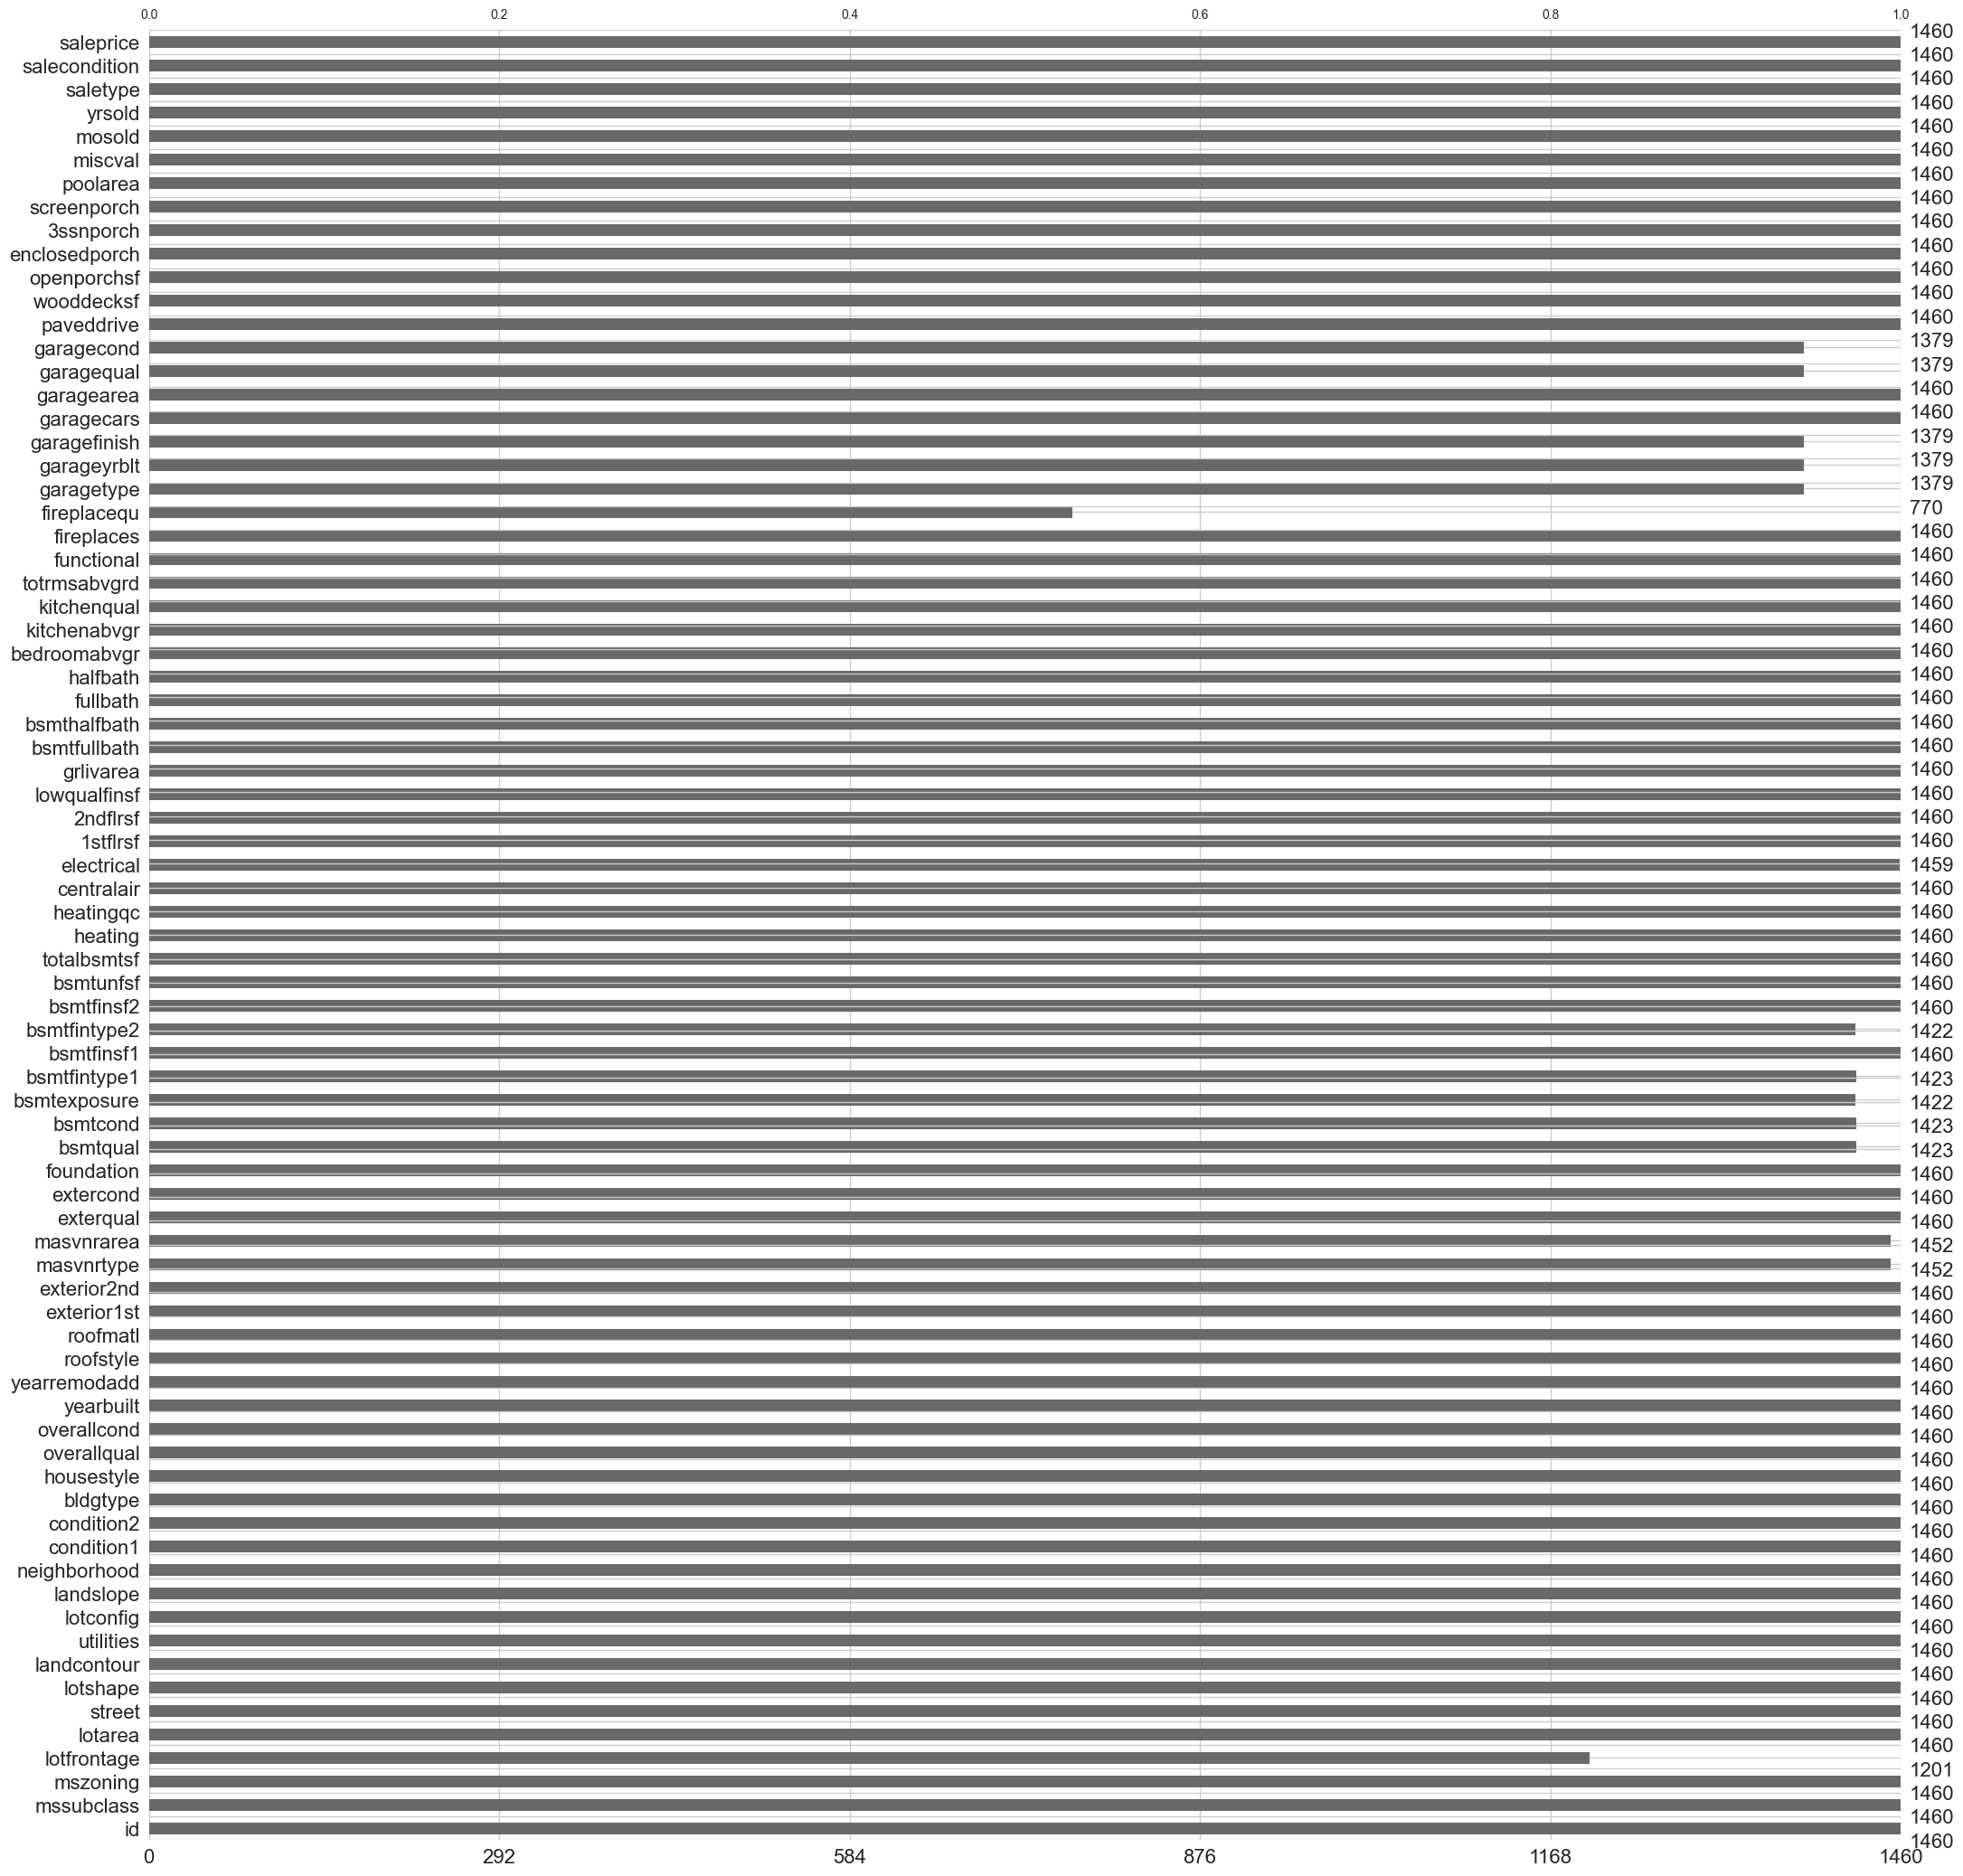

In [139]:
msno.bar(data,
         filter="top",  # select only features that have a completion rate >= p
         p=MODEL_PARAMS["MIN_COMPLETION_RATE"] # filter columns with % of missing values > 50%
        );

In [140]:
# Target: stat description
data[TARGET_NAME].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

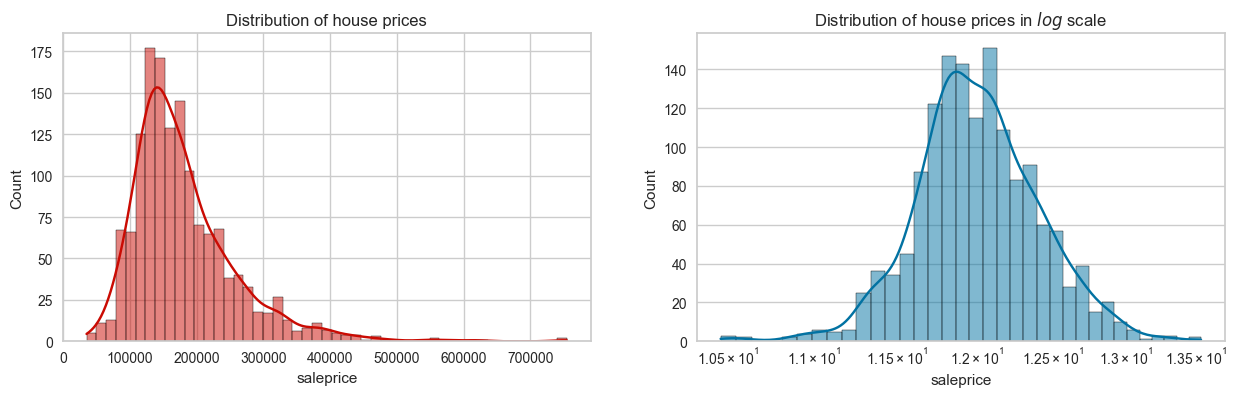

In [141]:
# Target distribution: raw vs log (box-cox transformation)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(data[TARGET_NAME], color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution of house prices')

sns.histplot(np.log(data[TARGET_NAME]), color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution of house prices in $log$ scale')
axes[1].set_xscale('log');

**Features**:
- 'bsmtfinsf1': 
- 'bsmtunfsf': 
- 'condition2': 
- 'exterqual': 
- 'foundation': 
- 'garagecars': 
- 'garagetype': 
- 'heating': 
- 'heatingqc': 
- 'housestyle': 
- 'lotarea': 
- 'masvnrarea': 
- 'masvnrtype': 
- 'miscfeature': 
- 'mosold': 
- 'mssubclass':
- 'mszoning'
- 'overallqual': 
- 'street': 
- 'totalbsmtsf'
- 'yearremodadd'
- 'yrsold'
- 'mosold',  # Month Sold (MM)
- "yearbuilt",  # Original construction date
- "yearremodadd",  # Remodel date (same as construction date if no remodeling or additions)|
- 'yrsold',  # Year Sold (YYYY)

**Target**: "saleprice"

Pretraitement des donnees de type date et ajout des nouvelles colonnes dans le dataset

Identifier les 'CategoricalFeatures' et les 'NumericalFeatures'

In [142]:
categorical_features = data.select_dtypes(include=["object", "bool"]).columns
logger.info(f"Categorical features:\n {categorical_features}\n")

numerical_features = data.select_dtypes(include="number").columns
logger.info(f"Numerical features:\n {numerical_features}")

2023-07-19 15:38:24.629 | INFO     | __main__:<module>:2 - Categorical features:
 Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

2023-07-19 15:38:24.634 | INFO     | __main__:<module>:5 - Numerical features:
 Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsm

ncols = 2  # number of columns in subplot
nrows = sum(divmod(len(categorical_features), ncols))  # number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 30))
axes = axes.ravel()

for i, col_name in enumerate(categorical_features):
    ax = axes[i]
    sns.violinplot(x=col_name, y=TARGET_NAME, data=data, palette='husl', ax=ax)

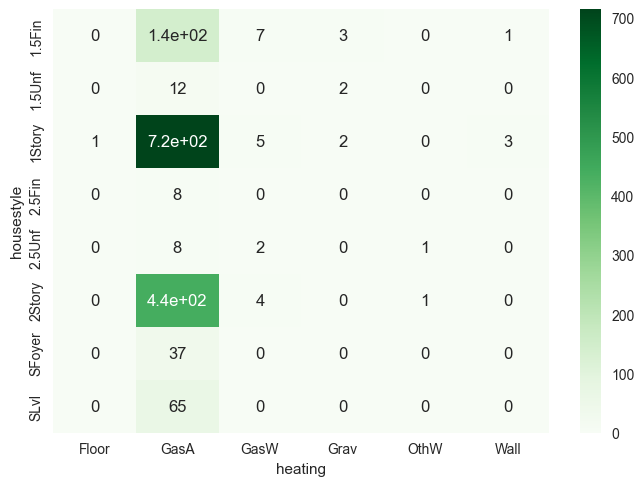

In [143]:
sns.heatmap(pd.crosstab(index=data.housestyle, columns=data.heating,
                        margins=False,
                        margins_name="Total", dropna=False),
            cmap="Greens", 
            annot=True,
            fmt='.2g',
           );  # px pour un graph interactif

In [144]:
!pip install ipykernel


In [145]:
!pip install --upgrade nbformat


In [146]:
!pip3 install --upgrade pip

In [147]:
#px.box(data_frame=data, x="heating", y=TARGET_NAME)

In [148]:
"""px.box(data_frame=data, y=TARGET_NAME,
       x="housestyle", color="heating",
       title="Box plot",
       #hover_data=[Heating"],
       boxmode="group",
       #notched=True, # used notched shape
       points=None,
       width=900,
       height=500,
      )
      """

'px.box(data_frame=data, y=TARGET_NAME,\n       x="housestyle", color="heating",\n       title="Box plot",\n       #hover_data=[Heating"],\n       boxmode="group",\n       #notched=True, # used notched shape\n       points=None,\n       width=900,\n       height=500,\n      )\n      '

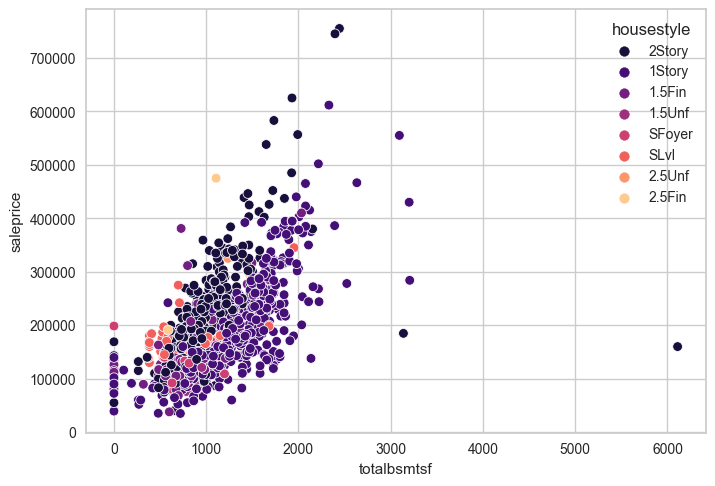

In [149]:
sns.scatterplot(x='totalbsmtsf', y=TARGET_NAME, data=data, palette='magma', hue='housestyle',);

In [150]:
Path(REPORT_DIR).mkdir(parents=True, exist_ok=True)

profile = ProfileReport(data, title="House price - profiling")
# profile.to_notebook_iframe()
profile.to_file(Path(REPORT_DIR, 'profiling_report.html'))

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


# Feature engineering / selections

# Critères de filtrage: Tp créer une fonction de preprocessng des données (suppresion des variables non pertinentes du point de vu Business/Stats)

# variables qualitatives
- 1 seule modalité (voire 1 modalité et des valeurs nulles)

# Variables quantitatives:
- valeur unique

Creation de la fonction de preprocessing pour les variables qualitatives avec 1 modalite et les variables quantitatives avec une valeur unique

In [160]:
def filter_features(dataset:pd.DataFrame):
    for feature in dataset.columns:
        if dataset[feature].nunique() == 1:
            dataset.drop(feature, inplace=True)
    return dataset

Fonction pour filtrer les features suivant le MIN_COMP_RATE est defini dans le utils.py

In [161]:
def filtre_min_completion_rate(dataset:pd.DataFrame, min_completion_rate: float):

    # Calculer le taux de valeurs manquantes dans chaque colonne
    missing_rates = dataset.isna().mean()
    # Filtrer les colonnes qui n'atteignent pas le taux minimal de complétion
    filtered_cols = missing_rates[missing_rates < min_completion_rate].index
    
    return dataset[filtered_cols]


Applications des fonctions de preprocessing 

In [162]:
data = data.assign(building_age=lambda dfr: dfr.yrsold - dfr.yearbuilt,
                   remodel_age=lambda dfr: dfr.yrsold - dfr.yearremodadd
                  )
data.head()

id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  landcontour utilities lotconfig landslope neighborhood condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  condition2 bldgtype housestyle  overallqual  overallcond  yearbuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   yearremodadd roofstyle roofmatl exterior1st exterior2nd masvnrtype  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   masvnrarea exterqual extercond foundation bsmtqual bsmtcond bsmtexposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  bsmtfintype1  bsmtfinsf1 bsmtfintype2  bsmtfinsf2  bsmtunfsf  totalbsmtsf  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  heating heatingqc centralair electrical  1stflrsf  2ndflrsf  lowqualfinsf  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   grlivarea  bsmtfullbath  bsmthalfbath  fullbath  halfbath  bedroomabvgr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   kitchenabvgr kitchenqual  totrmsabvgrd functional  fireplaces fireplacequ  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [155]:
data.loc[:, ["yrsold", "mosold", "yearbuilt", "yearremodadd"]]

yrsold  mosold  yearbuilt  yearremodadd
0       2008       2       2003          2003
1       2007       5       1976          1976
2       2008       9       2001          2002
3       2006       2       1915          1970
4       2008      12       2000          2000
...      ...     ...        ...           ...
1455    2007       8       1999          2000
1456    2010       2       1978          1988
1457    2010       5       1941          2006
1458    2010       4       1950          1996
1459    2008       6       1965          1965

[1460 rows x 4 columns]

In [156]:
data.yearbuilt.value_counts().head(10)#plot(kind="bar", figsize=(15, 7));

yearbuilt
2006    67
2005    64
2004    54
2007    49
2003    45
1976    33
1977    32
1920    30
1959    26
1998    25
Name: count, dtype: int64

Traitement des dates et ajout des nouvelles colonnes dans le dataset

In [163]:
data_first_preprocessing = filter_features(data[FEATURES])
data_second_preprocessing = filtre_min_completion_rate(data_first_preprocessing, MODEL_PARAMS["MIN_COMPLETION_RATE"])
data_second_preprocessing

bsmtfinsf1  bsmtunfsf condition2 exterqual foundation  garagecars  \
0            706        150       Norm        Gd      PConc           2   
1            978        284       Norm        TA     CBlock           2   
2            486        434       Norm        Gd      PConc           2   
3            216        540       Norm        TA     BrkTil           3   
4            655        490       Norm        Gd      PConc           3   
...          ...        ...        ...       ...        ...         ...   
1455           0        953       Norm        TA      PConc           2   
1456         790        589       Norm        TA     CBlock           2   
1457         275        877       Norm        Ex      Stone           1   
1458          49          0       Norm        TA     CBlock           1   
1459         830        136       Norm        Gd     CBlock           1   

     garagetype heating heatingqc housestyle  lotarea  masvnrarea masvnrtype  \
0        Attchd    GasA        Ex     2Story     8450       196.0    BrkFace   
1        Attchd    GasA        Ex     1Story     9600         0.0       None   
2        Attchd    GasA        Ex     2Story    11250       162.0    BrkFace   
3        Detchd    GasA        Gd     2Story     9550         0.0       None   
4        Attchd    GasA        Ex     2Story    14260       350.0    BrkFace   
...         ...     ...       ...        ...      ...         ...        ...   
1455     Attchd    GasA        Ex     2Story     7917         0.0       None   
1456     Attchd    GasA        TA     1Story    13175       119.0      Stone   
1457     Attchd    GasA        Ex     2Story     9042         0.0       None   
1458     Attchd    GasA        Gd     1Story     9717         0.0       None   
1459     Attchd    GasA        Gd     1Story     9937         0.0       None   

      mssubclass  overallqual saletype street  totalbsmtsf  building_age  \
0             60            7       WD   Pave          856             5   
1             20            6       WD   Pave         1262            31   
2             60            7       WD   Pave          920             7   
3             70            7       WD   Pave          756            91   
4             60            8       WD   Pave         1145             8   
...          ...          ...      ...    ...          ...           ...   
1455          60            6       WD   Pave          953             8   
1456          20            6       WD   Pave         1542            32   
1457          70            7       WD   Pave         1152            69   
1458          20            5       WD   Pave         1078            60   
1459          20            5       WD   Pave         1256            43   

      remodel_age  
0               5  
1              31  
2               6  
3              36  
4               8  
...           ...  
1455            7  
1456           22  
1457            4  
1458           14  
1459           43  

[1460 rows x 20 columns]

Suppression de la variable salecondition

In [171]:
print(MODEL_PARAMS)

{'MIN_COMPLETION_RATE': 0.5, 'FEATURES': ['bsmtfinsf1', 'bsmtunfsf', 'condition2', 'exterqual', 'foundation', 'garagecars', 'garagetype', 'heating', 'heatingqc', 'housestyle', 'lotarea', 'masvnrarea', 'masvnrtype', 'miscfeature', 'mssubclass', 'overallqual', 'saletype', 'street', 'totalbsmtsf', 'building_age', 'remodel_age'], 'TARGET': 'saleprice', 'DATA_LEAKAGE_COLUMNS': ['salecondition']}


In [177]:
for column_name in MODEL_PARAMS["DATA_LEAKAGE_COLUMNS"]:
    if column_name in data_second_preprocessing.columns:
        datas = data_second_preprocessing.drop(column_name, axis=1, inplace=True)
    else:
        datas = data_second_preprocessing

In [178]:
datas

bsmtfinsf1  bsmtunfsf condition2 exterqual foundation  garagecars  \
0            706        150       Norm        Gd      PConc           2   
1            978        284       Norm        TA     CBlock           2   
2            486        434       Norm        Gd      PConc           2   
3            216        540       Norm        TA     BrkTil           3   
4            655        490       Norm        Gd      PConc           3   
...          ...        ...        ...       ...        ...         ...   
1455           0        953       Norm        TA      PConc           2   
1456         790        589       Norm        TA     CBlock           2   
1457         275        877       Norm        Ex      Stone           1   
1458          49          0       Norm        TA     CBlock           1   
1459         830        136       Norm        Gd     CBlock           1   

     garagetype heating heatingqc housestyle  lotarea  masvnrarea masvnrtype  \
0        Attchd    GasA        Ex     2Story     8450       196.0    BrkFace   
1        Attchd    GasA        Ex     1Story     9600         0.0       None   
2        Attchd    GasA        Ex     2Story    11250       162.0    BrkFace   
3        Detchd    GasA        Gd     2Story     9550         0.0       None   
4        Attchd    GasA        Ex     2Story    14260       350.0    BrkFace   
...         ...     ...       ...        ...      ...         ...        ...   
1455     Attchd    GasA        Ex     2Story     7917         0.0       None   
1456     Attchd    GasA        TA     1Story    13175       119.0      Stone   
1457     Attchd    GasA        Ex     2Story     9042         0.0       None   
1458     Attchd    GasA        Gd     1Story     9717         0.0       None   
1459     Attchd    GasA        Gd     1Story     9937         0.0       None   

      mssubclass  overallqual saletype street  totalbsmtsf  building_age  \
0             60            7       WD   Pave          856             5   
1             20            6       WD   Pave         1262            31   
2             60            7       WD   Pave          920             7   
3             70            7       WD   Pave          756            91   
4             60            8       WD   Pave         1145             8   
...          ...          ...      ...    ...          ...           ...   
1455          60            6       WD   Pave          953             8   
1456          20            6       WD   Pave         1542            32   
1457          70            7       WD   Pave         1152            69   
1458          20            5       WD   Pave         1078            60   
1459          20            5       WD   Pave         1256            43   

      remodel_age  
0               5  
1              31  
2               6  
3              36  
4               8  
...           ...  
1455            7  
1456           22  
1457            4  
1458           14  
1459           43  

[1460 rows x 20 columns]

Recuperons les variables categorical et numerical des donnees traitees

In [181]:
categorical_features = datas.select_dtypes(include=["object", "bool"]).columns
logger.info(f"Categorical features:\n {categorical_features}\n")

numerical_features = datas.select_dtypes(include="number").columns
logger.info(f"Numerical features:\n {numerical_features}")

2023-07-19 16:11:27.738 | INFO     | __main__:<module>:2 - Categorical features:
 Index(['condition2', 'exterqual', 'foundation', 'garagetype', 'heating',
       'heatingqc', 'housestyle', 'masvnrtype', 'saletype', 'street'],
      dtype='object')

2023-07-19 16:11:27.746 | INFO     | __main__:<module>:5 - Numerical features:
 Index(['bsmtfinsf1', 'bsmtunfsf', 'garagecars', 'lotarea', 'masvnrarea',
       'mssubclass', 'overallqual', 'totalbsmtsf', 'building_age',
       'remodel_age'],
      dtype='object')


# Modeling

# Modèles à tester:
Dummy, linéaire, ensembliste (en partant du plus simple au plus complexe)


# Tracking avec mlflow

In [232]:
linear = LinearRegression()
dummy_model = DummyRegressor(strategy="mean")
random_forest = RandomForestRegressor(n_estimators=100, max_depth=5)
adaboost = AdaBoostRegressor(n_estimators=100)
voting = VotingRegressor(estimators=[("lr", linear), ("rf", random_forest)],weights=[0.5, 0.5])

modeles_definis = [linear, dummy_model, random_forest, adaboost, voting]
modeles_names = ["linear", "dummy_model", "random_forest", "adaboost", "voting"]

## Pipeline

In [179]:
def define_pipeline(numeric_transformer,
                   categorical_transformer,
                   estimator,
                   **kwargs):
     steps = [
        ('numeric_preprocessing', numeric_transformer),
        ('categorical_preprocessing', categorical_transformer),
        ('estimator', estimator)
    ]
    
    # Create the pipeline
     pipeline = Pipeline(steps, **kwargs)
    
     return pipeline

In [212]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                      ("scaler", StandardScaler())]
                              )

categorical_transformer = make_pipeline(*[SimpleImputer(strategy="constant", fill_value="undefined"),
                                          OneHotEncoder(handle_unknown="ignore")]
                                       )


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Append regressor to preprocessing pipeline.
# Now we have a full prediction pipeline.
reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)
reg

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(cop...
                                                                                 sparse='deprecated',
                                                                                 sparse_output=True))],
                                                           verbose=False),
                                                  Index(['condition2', 'exterqual', 'foundation', 'garagetype', 'heating',
       'heatingqc', 'housestyle', 'masvnrtype', 'saletype', 'street'],
      dtype='object'))],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  positive=False))],
         verbose=False)

Definition d'une fonction pour rendre la Pipeline plus generique avec les modeles utilises

In [233]:
def define_pipeline(model_name):
    reg = Pipeline(
        steps=[("preprocessor", preprocessor), ("regressor", model_name)]
    )
    return reg

Appliquer le pipeline a l'ensemble des modeles

In [ ]:
modeles = {name:define_pipeline(model) for name,model in zip(modeles_names, modeles_definis)}
modeles

## Train / test split

In [183]:
datas

bsmtfinsf1  bsmtunfsf condition2 exterqual foundation  garagecars  \
0            706        150       Norm        Gd      PConc           2   
1            978        284       Norm        TA     CBlock           2   
2            486        434       Norm        Gd      PConc           2   
3            216        540       Norm        TA     BrkTil           3   
4            655        490       Norm        Gd      PConc           3   
...          ...        ...        ...       ...        ...         ...   
1455           0        953       Norm        TA      PConc           2   
1456         790        589       Norm        TA     CBlock           2   
1457         275        877       Norm        Ex      Stone           1   
1458          49          0       Norm        TA     CBlock           1   
1459         830        136       Norm        Gd     CBlock           1   

     garagetype heating heatingqc housestyle  lotarea  masvnrarea masvnrtype  \
0        Attchd    GasA        Ex     2Story     8450       196.0    BrkFace   
1        Attchd    GasA        Ex     1Story     9600         0.0       None   
2        Attchd    GasA        Ex     2Story    11250       162.0    BrkFace   
3        Detchd    GasA        Gd     2Story     9550         0.0       None   
4        Attchd    GasA        Ex     2Story    14260       350.0    BrkFace   
...         ...     ...       ...        ...      ...         ...        ...   
1455     Attchd    GasA        Ex     2Story     7917         0.0       None   
1456     Attchd    GasA        TA     1Story    13175       119.0      Stone   
1457     Attchd    GasA        Ex     2Story     9042         0.0       None   
1458     Attchd    GasA        Gd     1Story     9717         0.0       None   
1459     Attchd    GasA        Gd     1Story     9937         0.0       None   

      mssubclass  overallqual saletype street  totalbsmtsf  building_age  \
0             60            7       WD   Pave          856             5   
1             20            6       WD   Pave         1262            31   
2             60            7       WD   Pave          920             7   
3             70            7       WD   Pave          756            91   
4             60            8       WD   Pave         1145             8   
...          ...          ...      ...    ...          ...           ...   
1455          60            6       WD   Pave          953             8   
1456          20            6       WD   Pave         1542            32   
1457          70            7       WD   Pave         1152            69   
1458          20            5       WD   Pave         1078            60   
1459          20            5       WD   Pave         1256            43   

      remodel_age  
0               5  
1              31  
2               6  
3              36  
4               8  
...           ...  
1455            7  
1456           22  
1457            4  
1458           14  
1459           43  

[1460 rows x 20 columns]

In [185]:
x_train, x_test, y_train, y_test = train_test_split(datas,
                                                    data[TARGET_NAME],
                                                    test_size=MODEL_PARAMS["TEST_SIZE"],
                                                    random_state=23)
logger.info(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_test.shape}\nY test: {y_test.shape}")

2023-07-19 16:44:27.171 | INFO     | __main__:<module>:5 - 
X train: (1022, 20)
Y train: (1022,)
X test: (438, 20)
Y test: (438,)


## Baseline

### Training

In [189]:
# pycaret
# lazy_predict

reg.fit(x_train,y_train)
# 5 modèles
# Expérimentation des modèles à stocker et suivre avec MLFlow

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(cop...
                                                                                 sparse='deprecated',
                                                                                 sparse_output=True))],
                                                           verbose=False),
                                                  Index(['condition2', 'exterqual', 'foundation', 'garagetype', 'heating',
       'heatingqc', 'housestyle', 'masvnrtype', 'saletype', 'street'],
      dtype='object'))],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  positive=False))],
         verbose=False)

Utilisation de Pycart

In [240]:
!pip3 install pycaret

  Obtaining dependency information for pycaret from https://files.pythonhosted.org/packages/f5/4b/2002980b046ac396618dfc152d384b812a78182b776ca77fe0ae5f80deac/pycaret-3.0.4-py3-none-any.whl.metadata
  Using cached pycaret-3.0.4-py3-none-any.whl.metadata (17 kB)
  Obtaining dependency information for ipywidgets>=7.6.5 from https://files.pythonhosted.org/packages/a3/af/9d5f256025100b578b11d7280e76fda349255666f752b618a613785cb58d/ipywidgets-8.0.7-py3-none-any.whl.metadata
  Using cached ipywidgets-8.0.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached pandas-1.5.3-cp311-cp311-macosx_10_9_x86_64.whl (11.9 MB)
  Using cached scikit_learn-1.2.2-cp311-cp311-macosx_10_9_x86_64.whl (9.0 MB)
  Using cached pyod-1.1.0.tar.gz (153 kB)
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for imbalanced-learn>=0.8.1 from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata


In [ ]:
from pycaret.regression import *


PROBLEME D'INSTALLATION DE PYCARET

Utilisation de MlFlow

In [ ]:
!pip3 install mlflow

In [254]:
import mlflow

modeles_mse = {}
for model_name, model in modeles.items():
    with mlflow.start_run(run_name=model_name):
        print(model_name)
        # Train the model
        model.fit(x_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(x_test)

        # Calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        modeles_mse[model_name] = [mse, model]
        
        score= model.score(x_test, y_test)

        # Log model parameters, metrics, and artifacts with MLflow
        mlflow.log_param("model", model_name)
        mlflow.log_param("n_estimators", getattr(model, 'n_estimators', 'N/A'))
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("r2", r2)
        mlflow.sklearn.log_model(model, "model")
        logger.info("R2")
        logger.info(r2)
        logger.info("MSE")
        logger.info(mse)
        logger.info("SCORE")
        logger.info(score)


linear


2023-07-19 22:29:17.652 | INFO     | __main__:<module>:26 - R2
2023-07-19 22:29:17.660 | INFO     | __main__:<module>:27 - 0.8268198076368634
2023-07-19 22:29:17.665 | INFO     | __main__:<module>:28 - MSE
2023-07-19 22:29:17.669 | INFO     | __main__:<module>:29 - 1033278938.166954
2023-07-19 22:29:17.670 | INFO     | __main__:<module>:30 - SCORE
2023-07-19 22:29:17.672 | INFO     | __main__:<module>:31 - 0.8268198076368634


dummy_model


2023-07-19 22:29:21.036 | INFO     | __main__:<module>:26 - R2
2023-07-19 22:29:21.038 | INFO     | __main__:<module>:27 - -6.4535428070389145e-06
2023-07-19 22:29:21.040 | INFO     | __main__:<module>:28 - MSE
2023-07-19 22:29:21.041 | INFO     | __main__:<module>:29 - 5966534580.988027
2023-07-19 22:29:21.043 | INFO     | __main__:<module>:30 - SCORE
2023-07-19 22:29:21.046 | INFO     | __main__:<module>:31 - -6.4535428070389145e-06


random_forest


2023-07-19 22:29:25.030 | INFO     | __main__:<module>:26 - R2
2023-07-19 22:29:25.032 | INFO     | __main__:<module>:27 - 0.8019167936022463
2023-07-19 22:29:25.033 | INFO     | __main__:<module>:28 - MSE
2023-07-19 22:29:25.036 | INFO     | __main__:<module>:29 - 1181862673.6838295
2023-07-19 22:29:25.038 | INFO     | __main__:<module>:30 - SCORE
2023-07-19 22:29:25.041 | INFO     | __main__:<module>:31 - 0.8019167936022463


adaboost


2023-07-19 22:29:28.766 | INFO     | __main__:<module>:26 - R2
2023-07-19 22:29:28.768 | INFO     | __main__:<module>:27 - 0.7448274705888338
2023-07-19 22:29:28.770 | INFO     | __main__:<module>:28 - MSE
2023-07-19 22:29:28.771 | INFO     | __main__:<module>:29 - 1522485895.4220088
2023-07-19 22:29:28.773 | INFO     | __main__:<module>:30 - SCORE
2023-07-19 22:29:28.774 | INFO     | __main__:<module>:31 - 0.7448274705888338


voting


2023-07-19 22:29:32.790 | INFO     | __main__:<module>:26 - R2
2023-07-19 22:29:32.792 | INFO     | __main__:<module>:27 - 0.8422256113476274
2023-07-19 22:29:32.795 | INFO     | __main__:<module>:28 - MSE
2023-07-19 22:29:32.796 | INFO     | __main__:<module>:29 - 941360270.7798221
2023-07-19 22:29:32.798 | INFO     | __main__:<module>:30 - SCORE
2023-07-19 22:29:32.800 | INFO     | __main__:<module>:31 - 0.8422256113476274


### Model évaluation

# Définir les métriques d'évaluation que vous souhaitez utiliser
Les metriques:
MSE
R2
SCORE

Meilleur modele

In [255]:
mse_min = min(modeles_mse.values())
value = {i for i in modeles_mse.keys() if modeles_mse[i]==mse_min}
value

{'voting'}

Donc le meilleur modele est celui du VotingRegressor

In [257]:
best_model = modeles_mse["voting"][1]
best_model

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(cop...
                                                                    ccp_alpha=0.0,
                                                                    criterion='squared_error',
                                                                    max_depth=5,
                                                                    max_features=1.0,
                                                                    max_leaf_nodes=None,
                                                                    max_samples=None,
                                                                    min_impurity_decrease=0.0,
                                                                    min_samples_leaf=1,
                                                                    min_samples_split=2,
                                                                    min_weight_fraction_leaf=0.0,
                                                                    n_estimators=100,
                                                                    n_jobs=None,
                                                                    oob_score=False,
                                                                    random_state=None,
                                                                    verbose=0,
                                                                    warm_start=False))],
                                 n_jobs=None, verbose=False,
                                 weights=[0.5, 0.5]))],
         verbose=False)

Recuperation du model de voting

## Tuning

In [ ]:
# optuna
# hyperopt
# GridSearch (sklearn)


# Model analysis & validation

## Performance analysis

In [249]:
!pip3 install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 422.5 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for scikit-image>=0.12 from https://files.pythonhosted.org/packages/08/53/f28cfb52248665b42db7e45a36ffc3a304fef46b308e5065fe2046e78daf/scikit_image-0.21.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/c7/b0/7b6c35b8636ed773325cdb6f5ac3cd36afba63d99e20ed59c521cf5018b4/imageio-2.31.1-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/2d/e5/cc8a8ca43685006bb3ca56fab60707f3f74700844b18634db0b1e8b4b93f/tifffile-2023.7.18-py3-none-any.whl.metadata
  Obtaining dependency information for lazy_loader>=0.2 from https://files.pythonhosted.org/packages/a1/c3/65b3814e155836acacf720e5be3b5757130346670ac454fee29d3eda1381/lazy_loader-0.3-py3-none-any.whl.metadata
   

In [ ]:
# features importances (globale ou locale): shap, lime

## Business performances

## Data drift

In [ ]:
# evidently

# Déploiement

In [265]:
# sauvargade du modèle en local: dill, joblib (sklearn), pickle
#Sauvegarde de modele en utilisant dill

dill.dump(best_model, open("../models/best_model.pkl", "wb"))